# 使用PaddlePaddle完成新冠疫情病例数预测

2019年12月以来，新冠疫情在全球肆虐，呈现大流行的特征。新型冠状病毒肺炎以发热、干咳、乏力等为主要表现，重症病例多在1周后出现呼吸困难，严重者快速进展为急性呼吸窘迫综合征、脓毒症休克、难以纠正的代谢性酸中毒和出凝血功能障碍及多器官功能衰竭等，对人们的健康造成了极其严重的威胁。同时，为抵御新冠病毒的扩散，不少国家和地区采取了封锁性防疫举措，全球经济复苏的进程因此受阻，政府债务不断上升。

在这种背景下，各国人民都期盼着疫情的结束，早日恢复往常的生产、生活方式。本文关注到这一问题，结合约翰斯·霍普金斯大学发布的全球新冠肺炎实时统计数据，通过时间卷积神经网络对时间序列建模，实现预测未来病例数的目的。

## 准备环境

在开始建模之前，我们需要导入必要的包，同时为了更好地展示数据结果，我们在这里配置画图功能。

In [1]:
import os
import sys

import paddle
import paddle.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from paddlenlp.seq2vec import TCNEncoder


# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

/mnt/qiujinxuan/PaddleNLP/paddlenlp/seq2vec/encoder.py:683: DeprecationWarning: invalid escape sequence \s
  """
/mnt/qiujinxuan/PaddleNLP/paddlenlp/seq2vec/encoder.py:740: DeprecationWarning: invalid escape sequence \s
  """


## 数据下载

数据集由约翰·霍普金斯大学系统科学与工程中心提供，每日最新数据可以从https://github.com/CSSEGISandData/COVID-19 仓库中获取，我们在本例中提供了2020年11月24日下载的病例数据。

In [2]:
# !wget https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

数据集中包含了国家、省份、纬度、经度以及从2020年1月22日至今的病例数等信息。

## 数据预览

数据集中包含了国家/地区、省份/州、纬度、经度、日期、病例数等信息。

In [3]:
df_all = pd.read_csv('time_series_covid19_confirmed_global.csv')
df_all.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/13/20,11/14/20,11/15/20,11/16/20,11/17/20,11/18/20,11/19/20,11/20/20,11/21/20,11/22/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,42969,43035,43240,43403,43628,43851,44228,44443,44503,44706
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,26701,27233,27830,28432,29126,29837,30623,31459,32196,32761
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,65975,66819,67679,68589,69591,70629,71652,72755,73774,74862
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,5725,5725,5872,5914,5951,6018,6066,6142,6207,6256
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,13228,13374,13451,13615,13818,13922,14134,14267,14413,14493


我们将对全世界的病例数进行预测，因此我们不需要关心具体国家的经纬度等信息，只需关注具体日期下的全球病例数即可。

In [4]:
df = df_all.iloc[:, 4:]
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

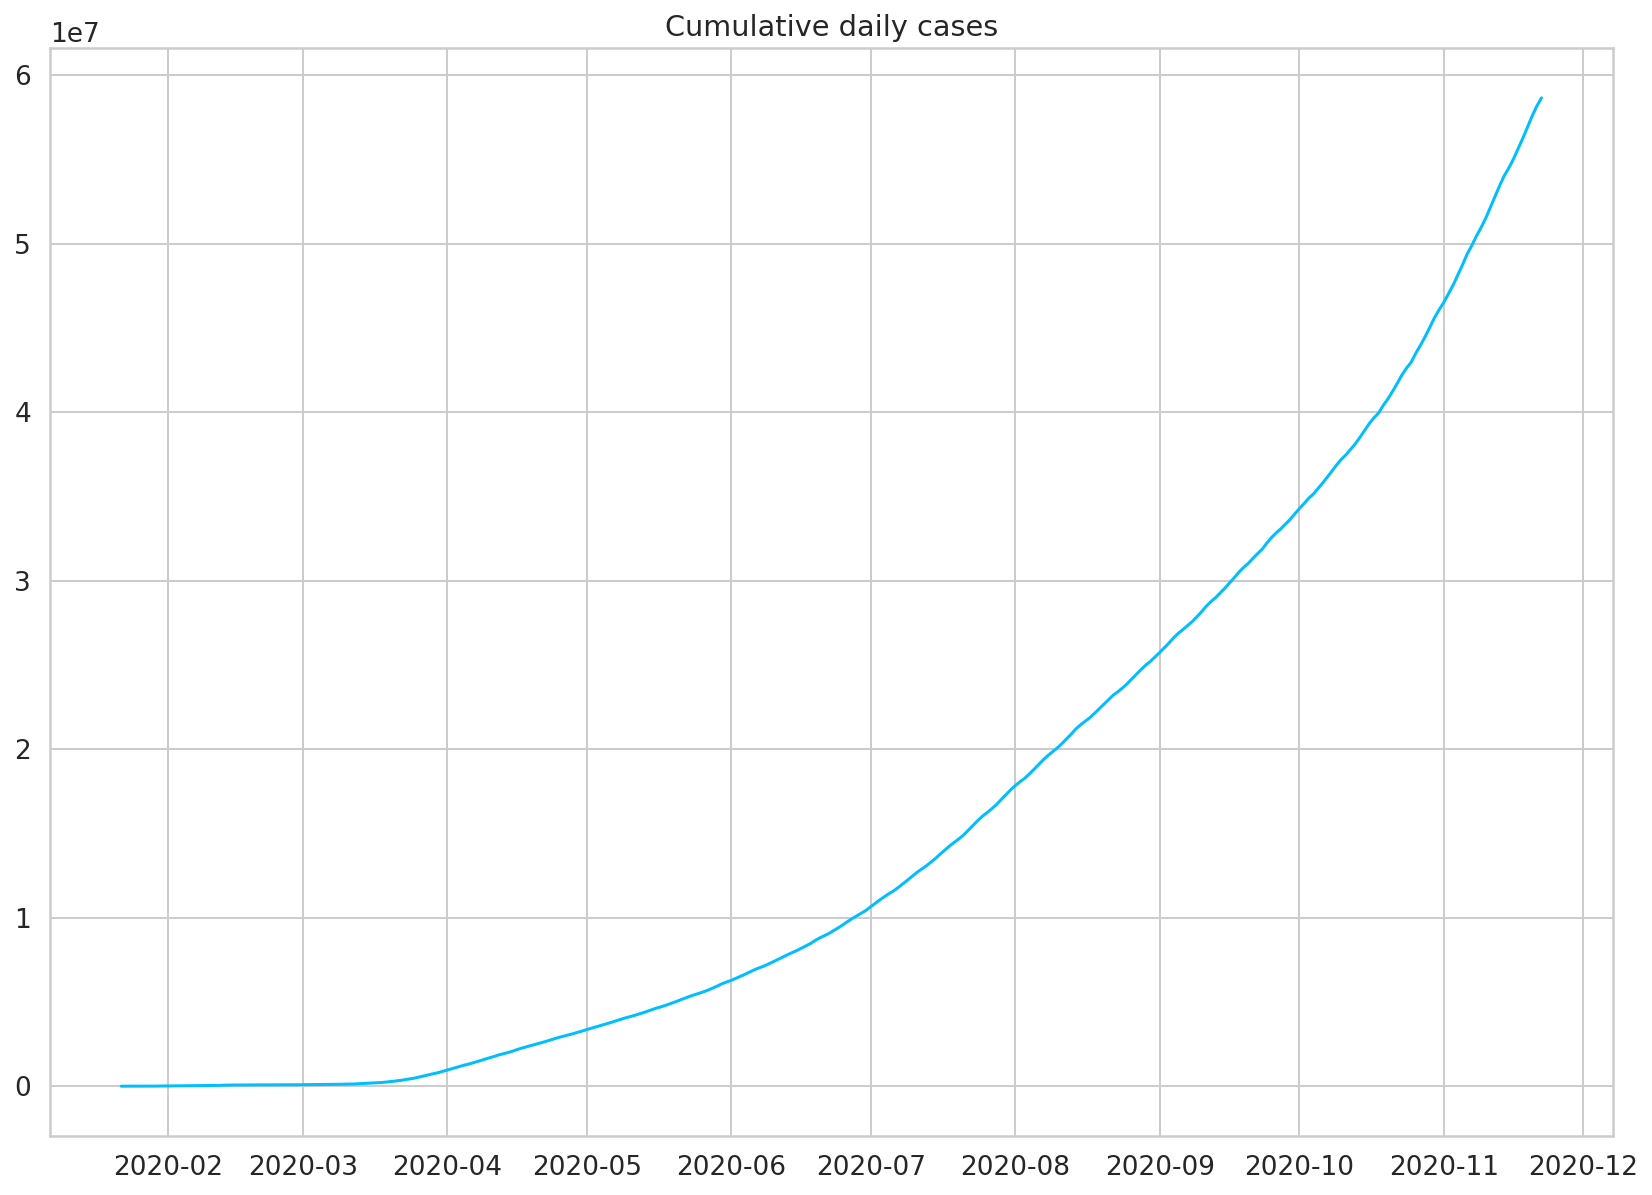

In [5]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

为了提高样本时间序列的平稳性，我们继续取一阶差分。

In [6]:
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

2020-01-22    555
2020-01-23     99
2020-01-24    287
2020-01-25    493
2020-01-26    684
dtype: int64

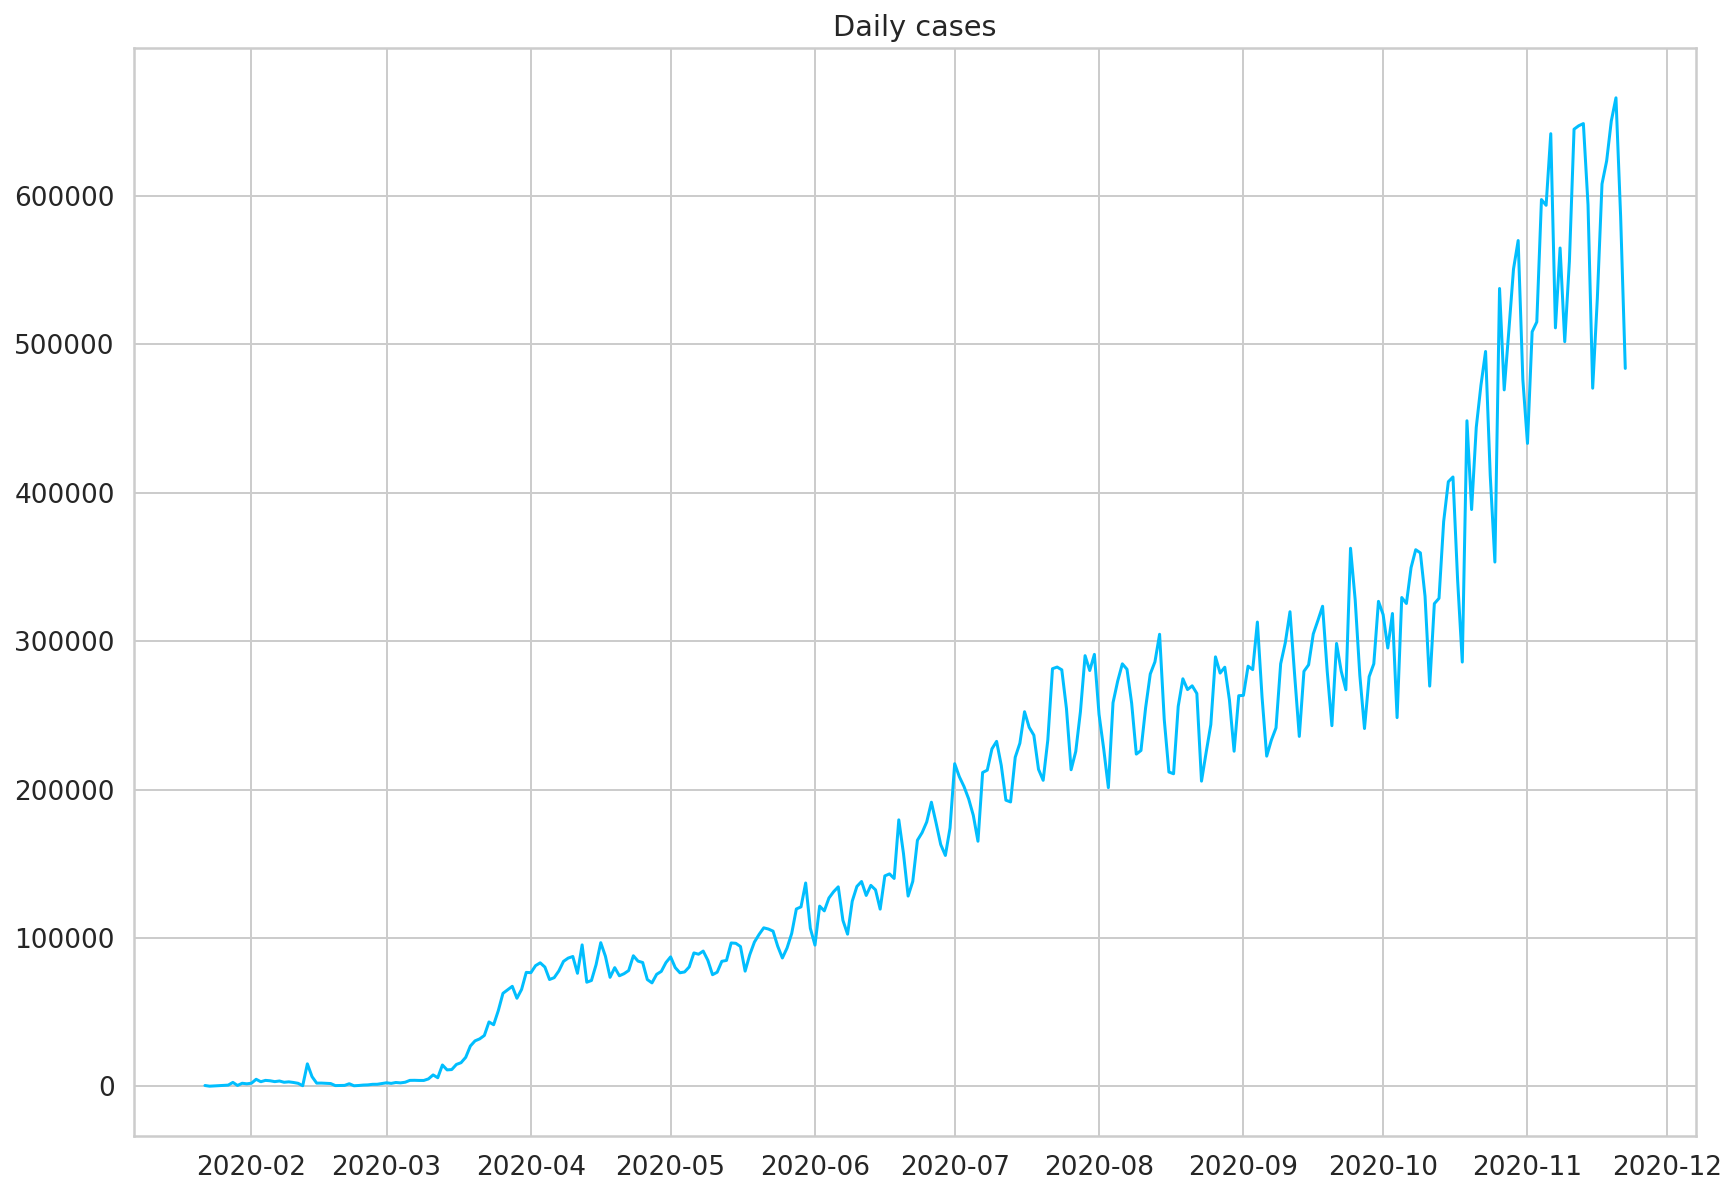

In [7]:
plt.plot(daily_cases)
plt.title("Daily cases");

## 数据预处理

首先划分数据集为训练集与验证集，我们取最后30天的数据作为测试集，其余作为训练集。

In [8]:
TEST_DATA_SIZE = 30

train_data = daily_cases[:-TEST_DATA_SIZE]
test_data = daily_cases[-TEST_DATA_SIZE:]

print("The number of the samples in train set is : %i"%train_data.shape[0])

The number of the samples in train set is : 276


为了提升模型收敛速度与性能，我们使用scikit-learn进行数据归一化。

In [9]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(np.expand_dims(train_data, axis=1)).astype('float32')
test_data = scaler.transform(np.expand_dims(test_data, axis=1)).astype('float32')

现在开始组建时间序列，可以用前10天的病例数预测当天的病例数。为了让测试集中的所有数据都能参与预测，我们将向测试集补充少量数据，这部分数据只会作为模型的输入。

In [10]:
SEQ_LEN = 10

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length+1):
        x = data[i:i+seq_length-1]
        y = data[i+seq_length-1]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(train_data, SEQ_LEN)
test_data = np.concatenate((train_data[-SEQ_LEN+1:],test_data),axis=0)
x_test, y_test = create_sequences(test_data, SEQ_LEN)

print("The shape of x_train is: %s"%str(x_train.shape))
print("The shape of y_train is: %s"%str(y_train.shape))
print("The shape of x_test is: %s"%str(x_test.shape))
print("The shape of y_test is: %s"%str(y_test.shape))

The shape of x_train is: (267, 9, 1)
The shape of y_train is: (267, 1)
The shape of x_test is: (30, 9, 1)
The shape of y_test is: (30, 1)


数据集处理完毕，将数据集封装到CovidDataset，以便模型训练、预测时调用。

In [11]:
class CovidDataset(paddle.io.Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label
        super(CovidDataset, self).__init__()

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        return [self.feature[index], self.label[index]]

train_dataset = CovidDataset(x_train, y_train)
test_dataset = CovidDataset(x_test, y_test)


## 组网

现在开始组建模型网络，我们采用时间卷积网络TCN作为特征提取器，将提取到的时序信息传送给全连接层获得最终的预测结果。

In [12]:
class TimeSeriesNetwork(nn.Layer):

  def __init__(self, input_size, next_k=1, num_channels=[64,128,256]):
    super(TimeSeriesNetwork, self).__init__()

    self.last_num_channel = num_channels[-1]

    self.tcn = TCNEncoder(
      input_size=input_size,
      num_channels=num_channels,
      kernel_size=2, 
      dropout=0.2
    )

    self.linear = nn.Linear(in_features= self.last_num_channel, out_features=next_k)

  def forward(self, x):
    tcn_out = self.tcn(x)
    y_pred = self.linear(tcn_out)
    return y_pred

network = TimeSeriesNetwork(input_size=1)

## 定义优化器、损失函数

在这里我们使用Adam优化器、均方差损失函数，为启动训练做最后的准备。

In [13]:
LR = 1e-3

model = paddle.Model(network)

optimizer = paddle.optimizer.Adam(
        learning_rate=LR, parameters=model.parameters())

loss = paddle.nn.MSELoss(reduction='sum')

model.prepare(optimizer, loss)

## 训练

配置必要的超参数，启动训练。

In [14]:
USE_GPU = False
TRAIN_EPOCH = 100
LOG_FREQ = 10
SAVE_DIR = os.path.join(os.getcwd(),"save_dir")
SAVE_FREQ = 10

if USE_GPU:
    paddle.set_device("gpu")
else:
    paddle.set_device("cpu")

model.fit(train_dataset, 
    batch_size=32,
    drop_last=True,
    epochs=TRAIN_EPOCH,
    log_freq=LOG_FREQ,
    save_dir=SAVE_DIR,
    save_freq=SAVE_FREQ,
    verbose=1
    )

Epoch 1/100
step 8/8 [==============================] - loss: 0.3619 - 101ms/step
save checkpoint at /mnt/qiujinxuan/PaddleNLP/examples/time_series/save_dir/0
Epoch 2/100
step 8/8 [==============================] - loss: 0.2746 - 53ms/step
Epoch 3/100
step 8/8 [==============================] - loss: 0.0907 - 62ms/step
Epoch 4/100
step 8/8 [==============================] - loss: 0.1740 - 55ms/step
Epoch 5/100
step 8/8 [==============================] - loss: 0.1825 - 56ms/step
Epoch 6/100
step 8/8 [==============================] - loss: 0.1334 - 56ms/step
Epoch 7/100
step 8/8 [==============================] - loss: 0.1089 - 53ms/step
Epoch 8/100
step 8/8 [==============================] - loss: 0.0948 - 57ms/step
Epoch 9/100
step 8/8 [==============================] - loss: 0.1400 - 61ms/step
Epoch 10/100
step 8/8 [==============================] - loss: 0.2118 - 52ms/step
Epoch 11/100
step 8/8 [==============================] - loss: 0.1471 - 56ms/step
save checkpoint at /mnt/qiuji

## 预测

使用训练完毕的模型，对测试集中的日期对应的病例数进行预测。


In [15]:
preds = model.predict(
        test_data=test_dataset
        )

Predict begin...
step 30/30 [==============================] - 12ms/step          
Predict samples: 30


## 数据后处理

将归一化的数据转换为原始数据，画出真实值对应的曲线和预测值对应的曲线。

In [16]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(np.array(preds).flatten(), axis=0)
).flatten()

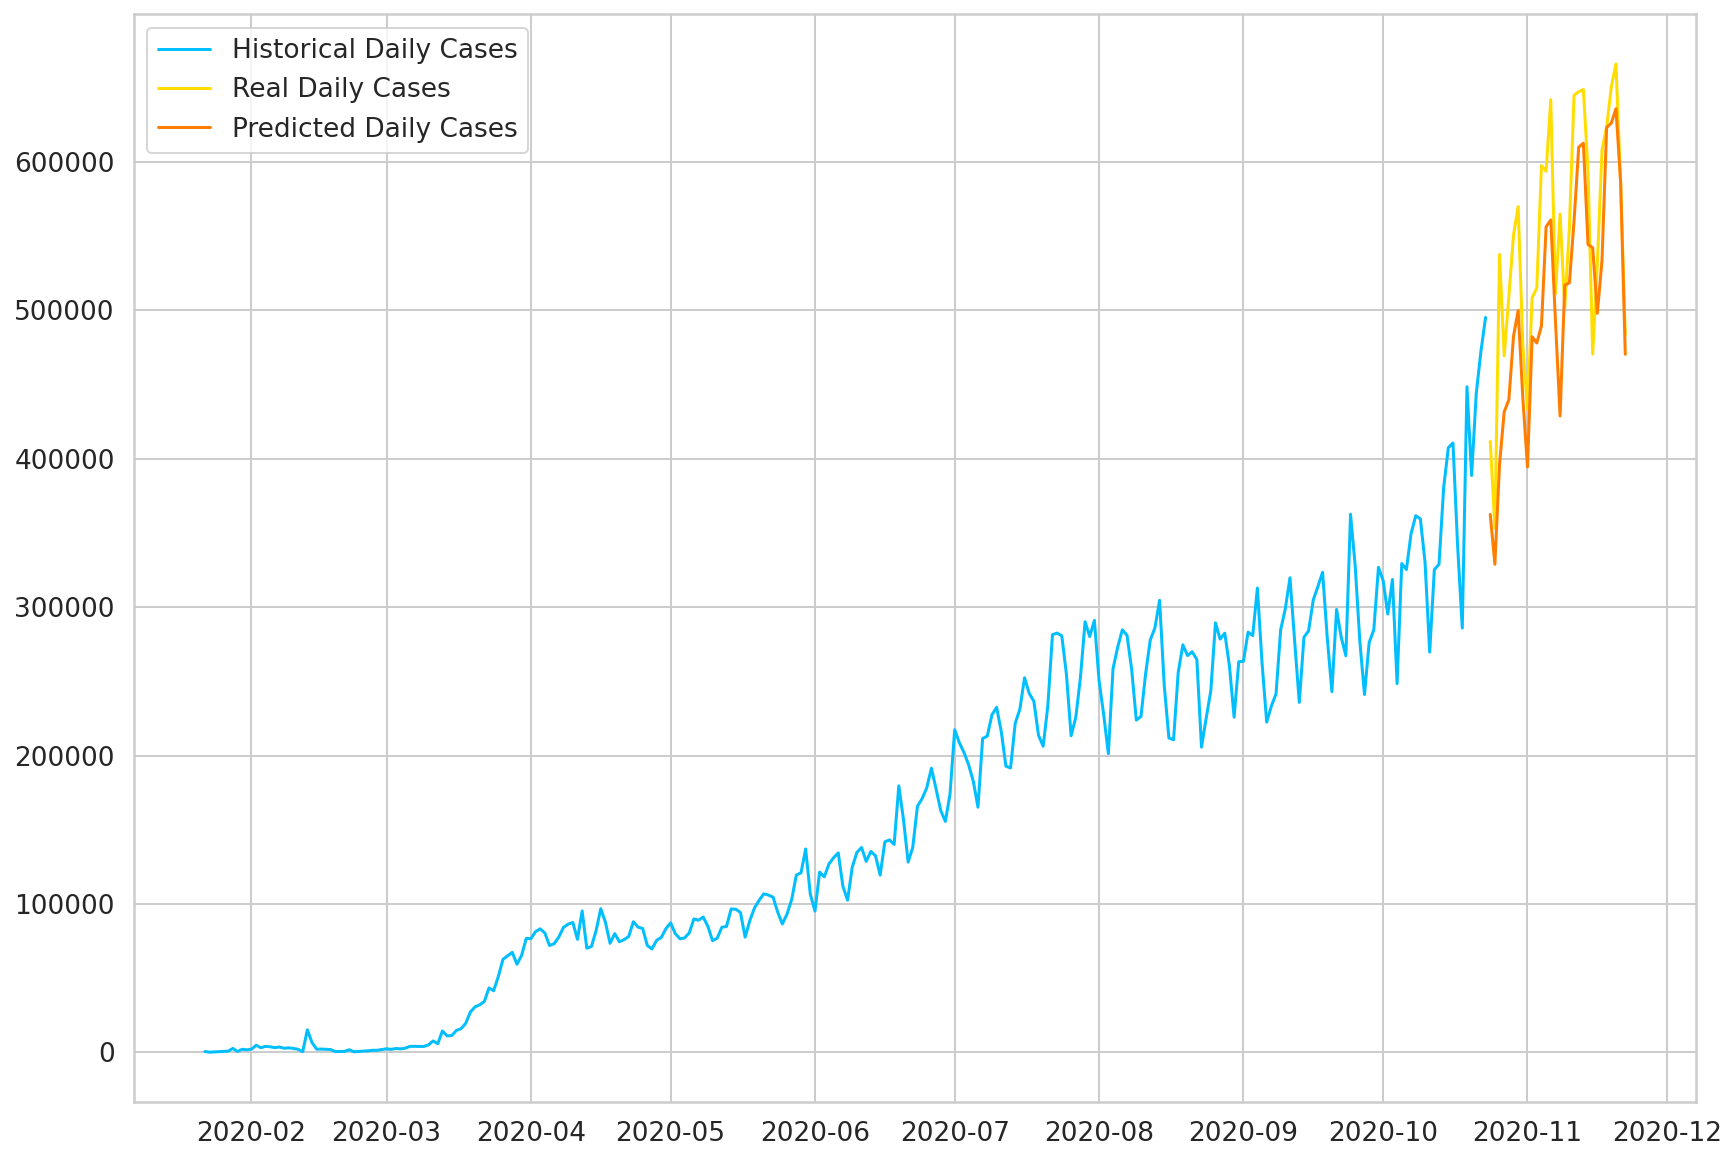

In [17]:
plt.plot(
  daily_cases.index[:len(train_data)], 
  scaler.inverse_transform(train_data).flatten(),
  label='Historical Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

## 进一步优化模型

从上图中，我们可以看到模型大体上预测到了病例数涨幅的升降情况，在具体数值上则出现了一些误差。读者可以发挥创造力，进一步提升模型的精度与功能，例如：

1. 预测未来n天

我们现在是用已知的9天病例数，预测第10天的病例数，我们可以将第10天的预测结果与前8天的真实病例数拼接，预测第11天的病例数，以此类推即可预测未来n天的病例数。

2. 优化模型网络

本文采用的是TCN模型，如果不考虑模型的速度性能，可以尝试LSTM, GRU, transformer等模型，进一步提升模型的拟合能力。

3. 优化模型超参数

本文没有对超参设置进行探索，读者可以探索设置更加合理的学习率，训练轮次，TCN通道数等。

4. 考虑更多的数据特征

本文只考虑了病例的日期，没有考虑政策、疫苗研制情况等具体环境的影响，读者可以搜集更多的新闻资料，加入更多的数据特征。

我们欢迎您对本任务做出进一步的探索，如果您可以修复某个 issue 或者增加一个新功能，欢迎给我们提交 PR。如果对应的 PR 被接受了，我们将根据贡献的质量和难度 进行打分（0-5 分，越高越好）。如果你累计获得了 10 分，可以联系我们获得面试机会或为你写推荐信。